In [1]:
# A script focused on searching for the statistical anomalies in the transaction dataset, to determine possible fraud

# Importing the necessary packages 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from matplotlib import pyplot as plt
import itertools

In [2]:
# Load the fraud detection dataset from kaggle
df = pd.read_csv("/Users/chiral/git_projects/fraud_detection/dataset/bank_transactions_data_2.csv")

In [21]:
# Creating functions that will make it easy to plot the characteristics
def create_scatter(x_var, y_var,dataset,folder):
    # Creates a 2D scatterplot for Z-Score fraud detection
    plt.figure(figsize=(6, 4))
    markers = {True: "s", False: "X"}
    sns.scatterplot(
        x=dataset[x_var],
        y=dataset[y_var],
        hue=dataset["Any_ZScore_Fraud"],
        palette={"Fraud": 'red', "Normal": 'blue'},
        markers=markers,
        alpha=0.7
    )
    plt.title('Z-Score Fraud Detection', fontsize=16)
    plt.xlabel(x_var, fontsize=14)
    plt.ylabel(y_var, fontsize=14)
    plt.legend(title='Fraud Potential', 
               # labels=["Fraud", "Normal"], 
               fontsize=12)
    plt.grid(True)
    plt.savefig("{}/{}_vs_{}.png".format(folder, x_var, y_var))
    plt.show()
    
def create_histo_2d(x_var, y_var, dataset):
    # 2D histogram for Z-Score fraud detection
    plt.figure(figsize=(6, 4))
    sns.histplot(
        x=dataset[x_var],
        y=dataset[y_var],
        hue=dataset["Fraud_ZScore_"+x_var],
        palette={True: 'red', False: 'blue'},
        alpha=0.7
    )
    plt.title('Z-Score Fraud Detection', fontsize=16)
    plt.xlabel(x_var, fontsize=14)
    plt.ylabel(y_var, fontsize=14)
    plt.legend(title='Fraud', 
               labels=['Fraud', 'Normal'], 
               fontsize=12)
    plt.grid(True)
    plt.show()

def create_histo_1d(x_var, dataset):
    # Histogram for plotting the frequency of a variable occurrence
    plt.figure(figsize=(6, 4))
    sns.histplot(
        x=dataset[x_var],
        alpha=0.7
    )
    plt.title(x_var, fontsize=16)
    plt.xlabel(x_var, fontsize=14)
    plt.grid(True)
    plt.show()

def create_histo_1_zscore(x_var, dataset, z_threshold):
    # Histogram for plotting the frequency of a variable occurrence
    plt.figure(figsize=(6, 4))
    sns.histplot(
        x=dataset[x_var],
        hue=dataset[x_var] > z_threshold,
        palette={True: 'red', False: 'blue'},
        alpha=0.7
    )
    plt.title(x_var, fontsize=16)
    plt.xlabel(x_var+ " Z-Score", fontsize=14)
    plt.legend(title='Fraud Inidcator', 
               labels=["Potential Fraud",'Normal'], 
               fontsize=12)
    plt.grid(True)
    plt.show()


In [4]:
df[:10]

TransactionID AccountID  TransactionAmount TransactionDate TransactionType  \
0      TX000001   AC00128              14.09   4/11/23 16:29           Debit   
1      TX000002   AC00455             376.24   6/27/23 16:44           Debit   
2      TX000003   AC00019             126.29   7/10/23 18:16           Debit   
3      TX000004   AC00070             184.50    5/5/23 16:32           Debit   
4      TX000005   AC00411              13.45  10/16/23 17:51          Credit   
5      TX000006   AC00393              92.15    4/3/23 17:15           Debit   
6      TX000007   AC00199               7.08   2/15/23 16:36          Credit   
7      TX000008   AC00069             171.42    5/8/23 17:47          Credit   
8      TX000009   AC00135             106.23   3/21/23 16:59          Credit   
9      TX000010   AC00385             815.96   3/31/23 16:06           Debit   

        Location DeviceID       IP Address MerchantID Channel  CustomerAge  \
0      San Diego  D000380   162.198.218.92       M015     ATM           70   
1        Houston  D000051      13.149.61.4       M052     ATM           68   
2           Mesa  D000235   215.97.143.157       M009  Online           19   
3        Raleigh  D000187   200.13.225.150       M002  Online           26   
4        Atlanta  D000308     65.164.3.100       M091  Online           26   
5  Oklahoma City  D000579   117.67.192.211       M054     ATM           18   
6        Seattle  D000241  140.212.253.222       M019     ATM           37   
7   Indianapolis  D000500    92.214.76.157       M020  Branch           67   
8        Detroit  D000690    24.148.92.177       M035  Branch           51   
9      Nashville  D000199     32.169.88.41       M007     ATM           55   

  CustomerOccupation  TransactionDuration  LoginAttempts  AccountBalance  \
0             Doctor                   81              1         5112.21   
1             Doctor                  141              1        13758.91   
2            Student                   56              1         1122.35   
3            Student                   25              1         8569.06   
4            Student                  198              1         7429.40   
5            Student                  172              1          781.68   
6             Doctor                  139              1        13316.71   
7            Retired                  291              1         2796.24   
8           Engineer                   86              1         9095.14   
9             Doctor                  120              1         1021.88   

  PreviousTransactionDate  
0           11/4/24 08:08  
1           11/4/24 08:09  
2           11/4/24 08:07  
3           11/4/24 08:09  
4           11/4/24 08:06  
5           11/4/24 08:06  
6           11/4/24 08:10  
7           11/4/24 08:10  
8           11/4/24 08:11  
9           11/4/24 08:06

In [5]:
# Plot the amount of time between purchases, which could indicate fraud
# Convert the current and last transaction time to a date time format
df['TransactionDate_dt'] = pd.to_datetime(df['TransactionDate'], format='%m/%d/%y %H:%M')
df['PreviousTransactionDate_dt'] = pd.to_datetime(df['PreviousTransactionDate'], format='%m/%d/%y %H:%M')

df['TransactionDate_hour'] = df['TransactionDate_dt'].dt.hour
df['TransactionWeekNumber'] = df['TransactionDate_dt'].dt.isocalendar().week

print(df['TransactionDate'][0])
print(df['PreviousTransactionDate'][0])
print(df['TransactionWeekNumber'][0])


print(df['PreviousTransactionDate_dt'][0]-df['TransactionDate_dt'][0])
# Calculate the seconds between the purchases, normalize by 10k to 
df['DaysSinceLastPurchase'] = (df['PreviousTransactionDate_dt']-df['TransactionDate_dt']).dt.total_seconds()/(3600*24)
df['DaysSinceLastPurchase'][0]

4/11/23 16:29
11/4/24 08:08
15
572 days 15:39:00


572.6520833333333

In [6]:
df.describe()

TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   
std           291.946243    17.792198            69.963757       0.602662   

       AccountBalance             TransactionDate_dt  \
count     2512.000000                           2512   
mean      5114.302966  2023-07-05 20:31:41.918789888   
min        101.250000            2023-01-02 16:00:00   
25%       1504.370000            2023-04-03 16:21:15   
50%       4735.510000            2023-07-07 17:49:00   
75%       7678.820000            2023-10-06 18:40:15   
max      14977.990000            2024-01-01 18:21:00   
std       3900.942499                            NaN   

          PreviousTransactionDate_dt  TransactionDate_hour  \
count                           2512           2512.000000   
mean   2024-11-04 08:08:52.882165504             16.626194   
min              2024-11-04 08:06:00             16.000000   
25%              2024-11-04 08:07:00             16.000000   
50%              2024-11-04 08:09:00             16.000000   
75%              2024-11-04 08:10:00             17.000000   
max              2024-11-04 08:12:00             18.000000   
std                              NaN              0.731059   

       TransactionWeekNumber  DaysSinceLastPurchase  
count                 2512.0            2512.000000  
mean               26.830016             487.484155  
min                      1.0             307.572917  
25%                     13.0             394.560069  
50%                     27.0             485.598264  
75%                     40.0             580.658333  
max                     52.0             671.674306  
std                15.194352             106.379691

In [7]:
# Calculate the z score for the variables that have continuous values

# Define numeric columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'CustomerAge', "DaysSinceLastPurchase", "TransactionDate_hour"]
# numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'CustomerAge', "DaysSinceLastPurchase", "TransactionDate_hour","TransactionWeekNumber"]

df[numeric_cols]
# Make plots of variables themselves
# for var in numeric_cols:
    # create_histo_1d(var,df)


TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance  \
0                 14.09                   81              1         5112.21   
1                376.24                  141              1        13758.91   
2                126.29                   56              1         1122.35   
3                184.50                   25              1         8569.06   
4                 13.45                  198              1         7429.40   
...                 ...                  ...            ...             ...   
2507             856.21                  109              1        12690.79   
2508             251.54                  177              1          254.75   
2509              28.63                  146              1         3382.91   
2510             185.97                   19              1         1776.91   
2511             243.08                   93              1          131.25   

      CustomerAge  DaysSinceLastPurchase  TransactionDate_hour  
0              70             572.652083                    16  
1              68             495.642361                    16  
2              19             482.577083                    18  
3              26             548.650694                    16  
4              26             384.593750                    17  
...           ...                    ...                   ...  
2507           33             557.626389                    17  
2508           48             592.607639                    17  
2509           56             440.625000                    17  
2510           23             618.658333                    16  
2511           24             628.656944                    16  

[2512 rows x 7 columns]

In [8]:
# Calculate Z-Scores to detect anomalies

# Here we take the absolute value of the score, we only care about if its greater or less than +-X, not its position relative to the mean
abs_z_scores = np.abs(zscore(df[numeric_cols]))

# Calculate z-score using scipy
z_scores = zscore(df[numeric_cols])
z_scores

TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance  \
0             -0.971275            -0.552443      -0.206794       -0.000537   
1              0.269440             0.305314      -0.206794        2.216472   
2             -0.586882            -0.909842      -0.206794       -1.023534   
3             -0.387456            -1.353017      -0.206794        0.885797   
4             -0.973468             1.120184      -0.206794        0.593589   
...                 ...                  ...            ...             ...   
2507           1.913802            -0.152156      -0.206794        1.942606   
2508          -0.157779             0.819969      -0.206794       -1.245986   
2509          -0.921462             0.376794      -0.206794       -0.443928   
2510          -0.382420            -1.438793      -0.206794       -0.855705   
2511          -0.186763            -0.380892      -0.206794       -1.277652   

      CustomerAge  DaysSinceLastPurchase  TransactionDate_hour  
0        1.423718               0.800763             -0.856729  
1        1.311287               0.076705             -0.856729  
2       -1.443277              -0.046137              1.879574  
3       -1.049768               0.575098             -0.856729  
4       -1.049768              -0.967392              0.511423  
...           ...                    ...                   ...  
2507    -0.656259               0.659489              0.511423  
2508     0.186975               0.988388              0.511423  
2509     0.636700              -0.440577              0.511423  
2510    -1.218415               1.233321             -0.856729  
2511    -1.162199               1.327329             -0.856729  

[2512 rows x 7 columns]

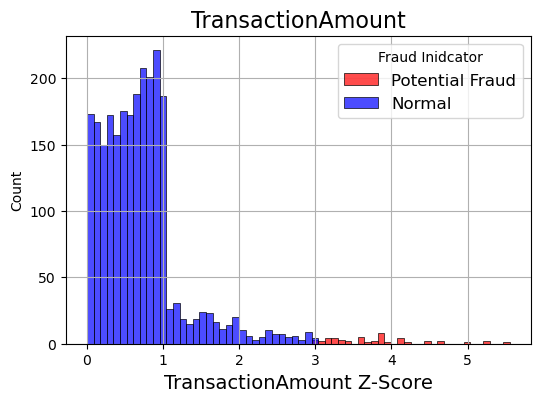

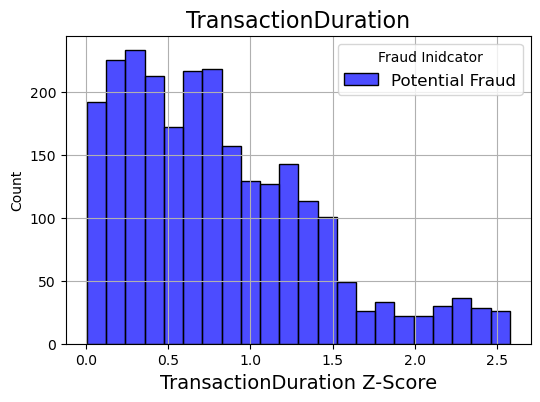

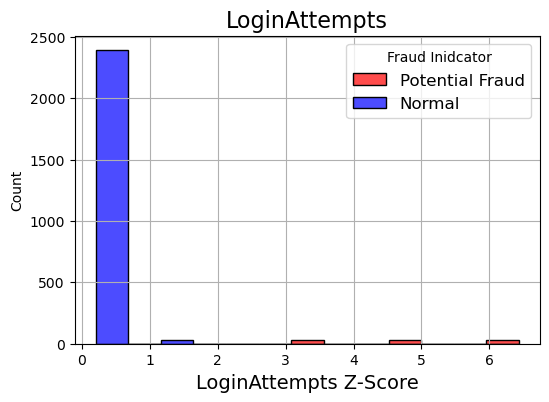

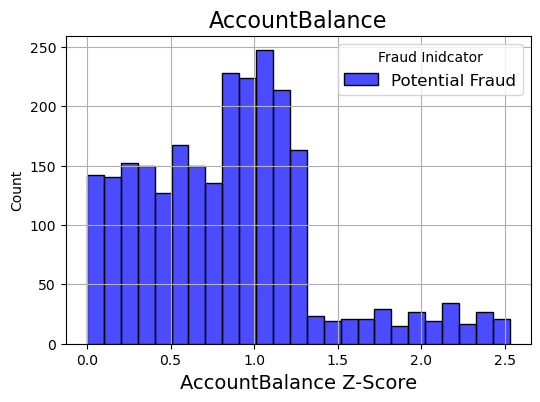

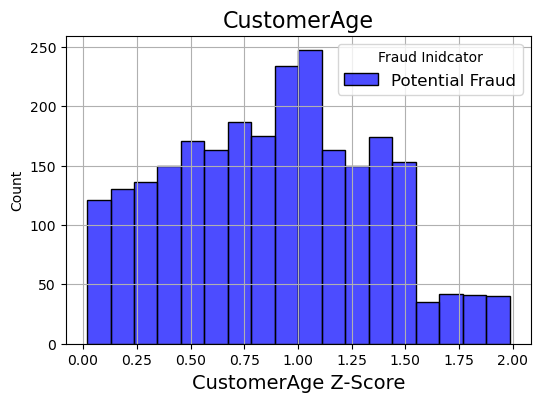

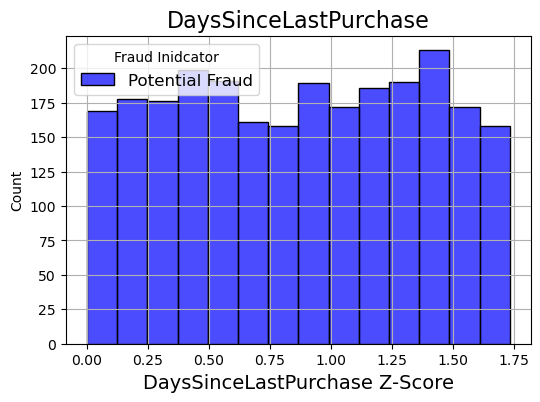

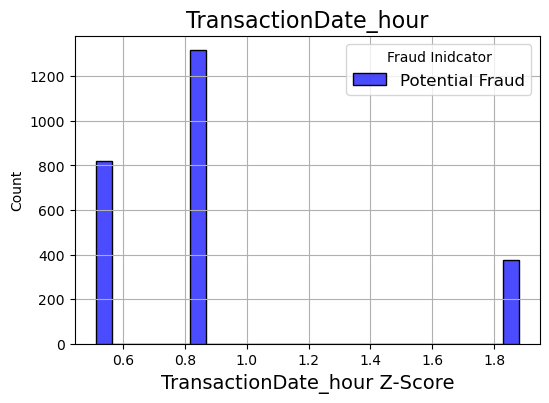

In [9]:
# Make plots of the Z distributions of these variables
# There are a few potential instances of fraud in TransactionAmounts and LoginAttempts
# I am setting the anomaly threshold to above 3 sigma
z_threshold = 3
for var in numeric_cols:
      create_histo_1_zscore(var,abs_z_scores,z_threshold)

In [10]:
# Flag any data points that have a Z-score greater than 3 in their distribution
# Data points with a Z-Scores greater than 2, lie above a threshold where 95% of the data is contained, and so are anomalous
# Where ANY of the variable characteristics lie above 3 sigma
df['Any_ZScore_Fraud'] = (abs_z_scores > 3).any(axis=1)

# Renaming the True and False Flags for proper coloring
df["Any_ZScore_Fraud"] = df["Any_ZScore_Fraud"].map({True: "Fraud", False: "Normal"})

# Determining the total number of fraud cases
fraud_count =(df["Any_ZScore_Fraud"]=="Fraud").sum()

In [11]:
# Creating columns for each of the fraud metrics to see if any cases are in the 3 sigma tail
for col in numeric_cols:
    df['Fraud_ZScore_'+col] = (z_scores[col] > 3)
    z_scores['Fraud_ZScore_'+col] = (z_scores[col] > 3)

In [20]:
# Draw the statistical anomalies with respect to the other variables
# Draw a 2D plot to show z scores for 2 variables

numeric_cols.append("CustomerOccupation","TransactionType")
print(numeric_cols)
# Making a combination of all of the variables of interest, for plotting
combinations = list(itertools.combinations(numeric_cols, 2))




['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'CustomerAge', 'DaysSinceLastPurchase', 'TransactionDate_hour', 'CustomerOccupation', 'TransactionType']


TransactionAmount TransactionDuration


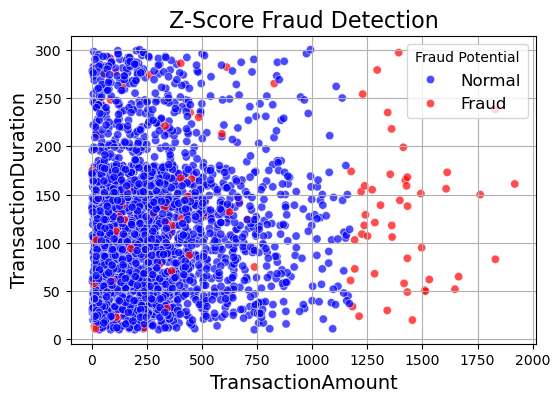

TransactionAmount LoginAttempts


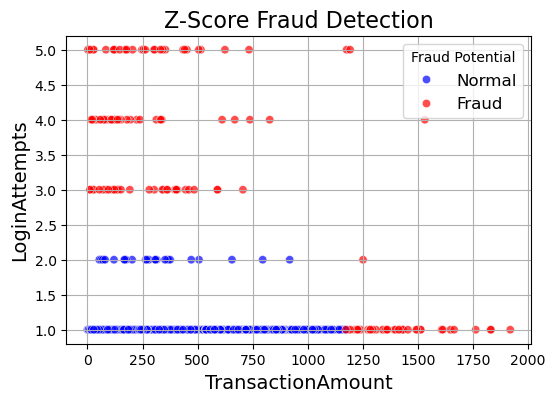

TransactionAmount AccountBalance


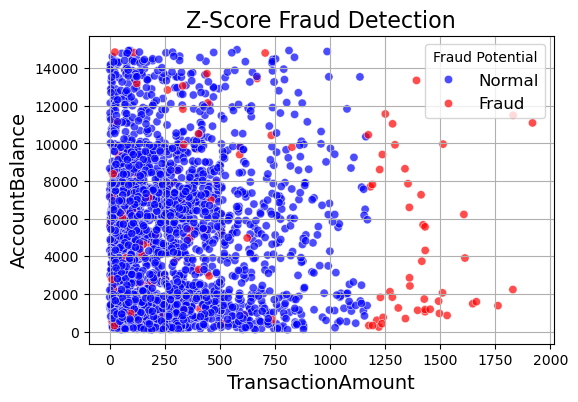

TransactionAmount CustomerAge


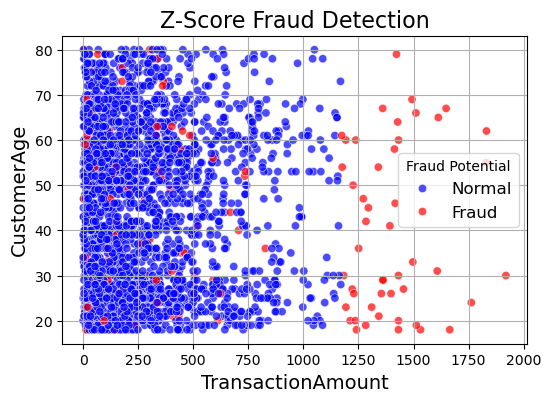

TransactionAmount DaysSinceLastPurchase


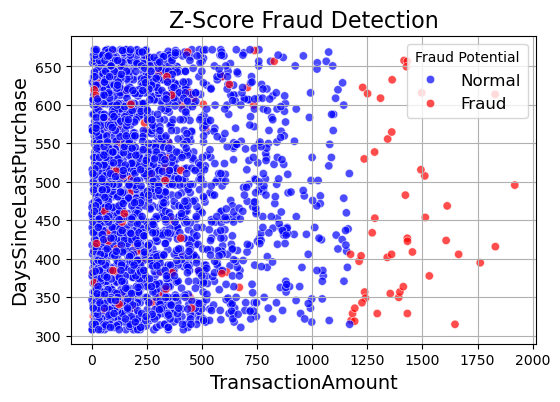

TransactionAmount TransactionDate_hour


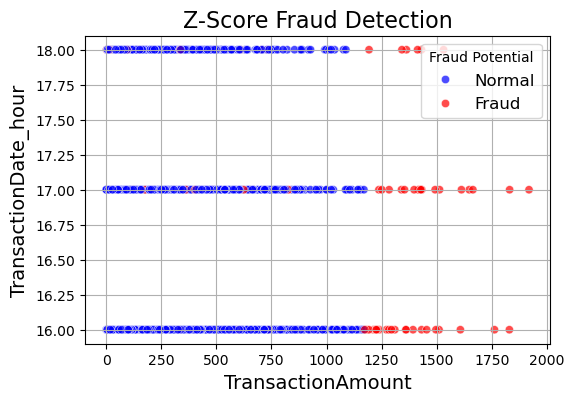

TransactionAmount CustomerOccupation


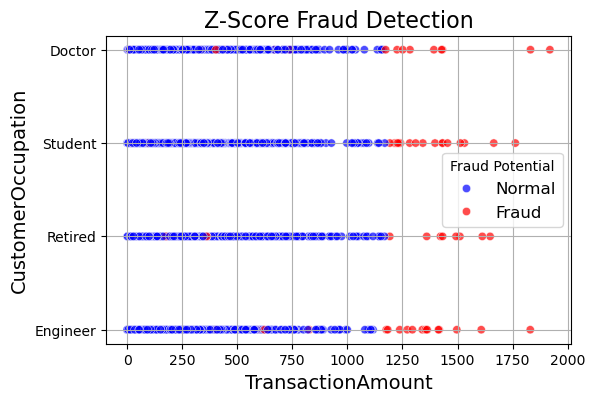

TransactionAmount TransactionType


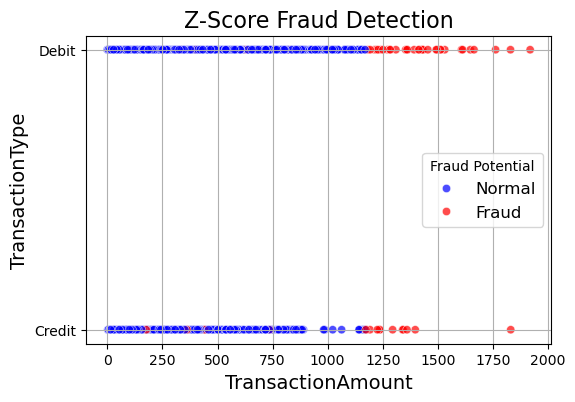

TransactionDuration LoginAttempts


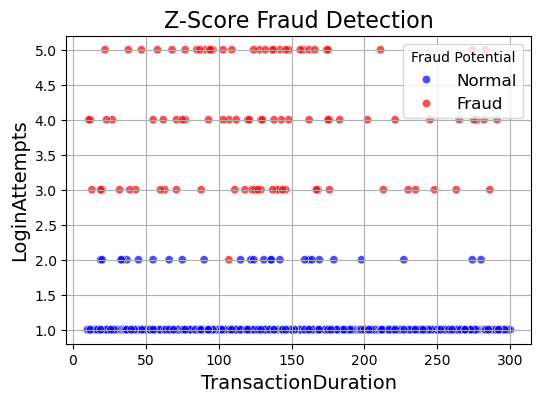

TransactionDuration AccountBalance


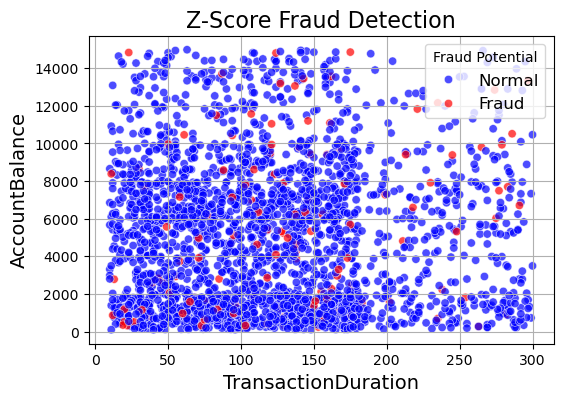

TransactionDuration CustomerAge


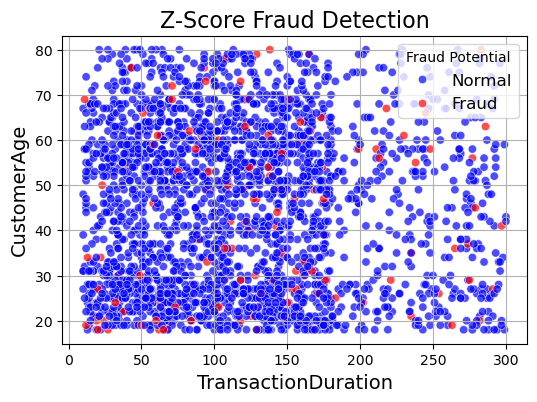

TransactionDuration DaysSinceLastPurchase


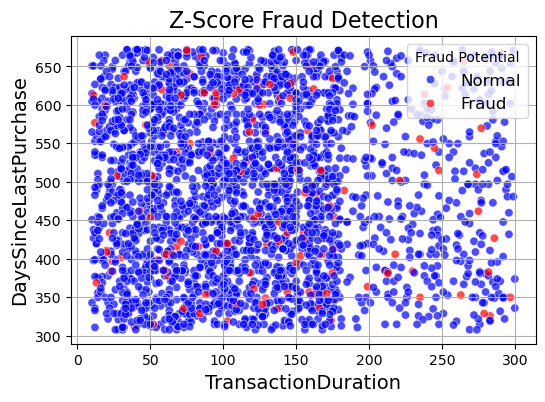

TransactionDuration TransactionDate_hour


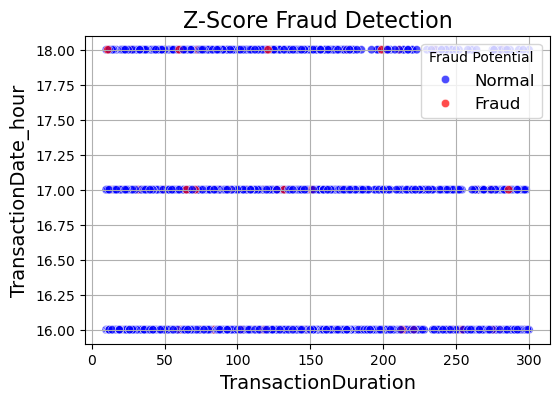

TransactionDuration CustomerOccupation


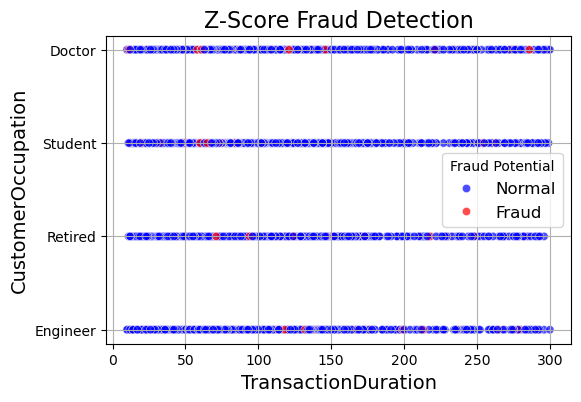

TransactionDuration TransactionType


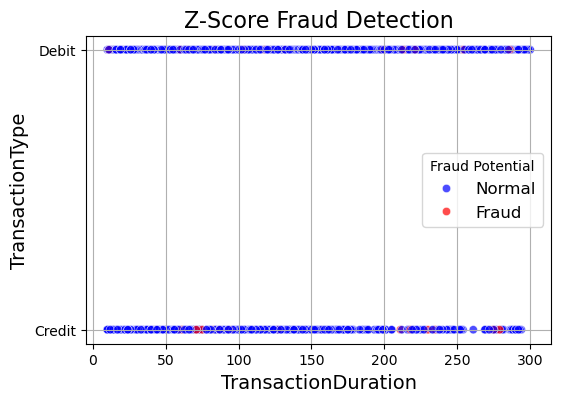

LoginAttempts AccountBalance


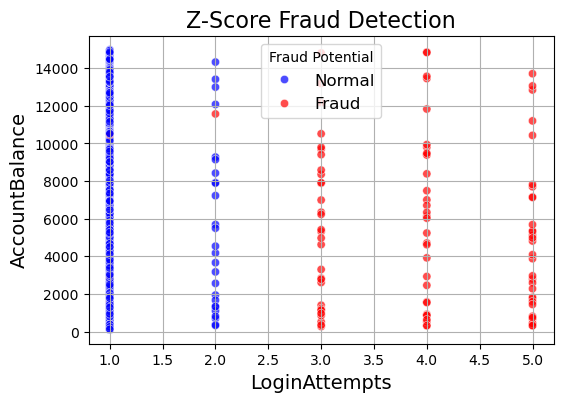

LoginAttempts CustomerAge


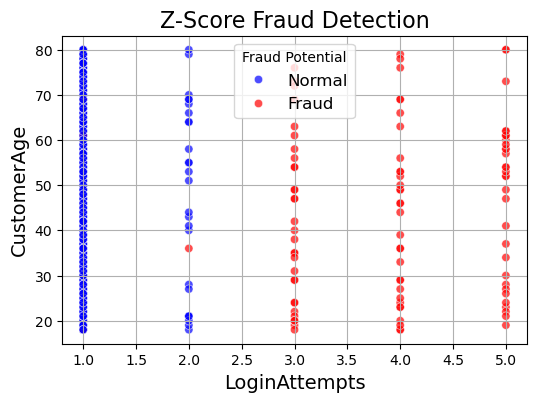

LoginAttempts DaysSinceLastPurchase


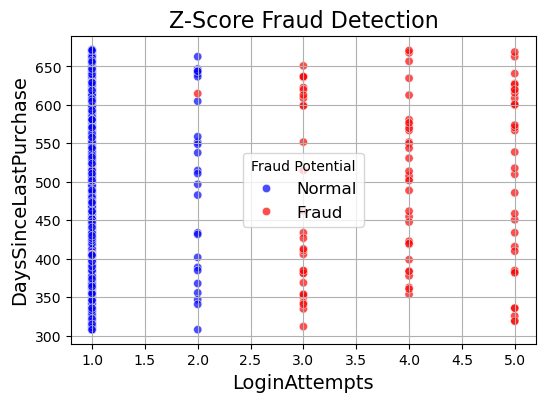

LoginAttempts TransactionDate_hour


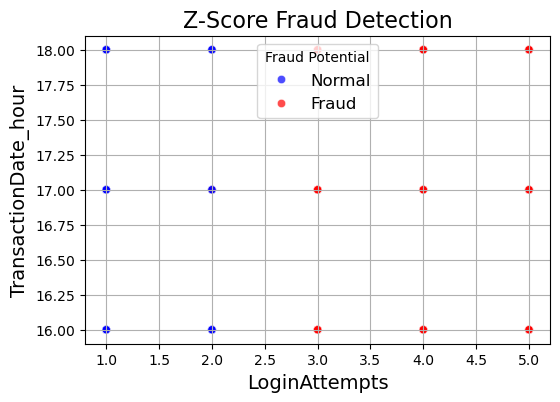

LoginAttempts CustomerOccupation


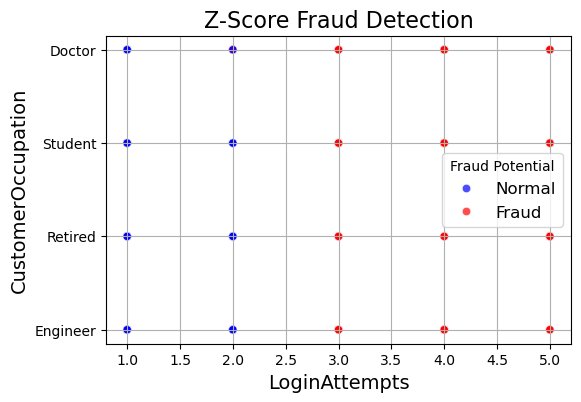

LoginAttempts TransactionType


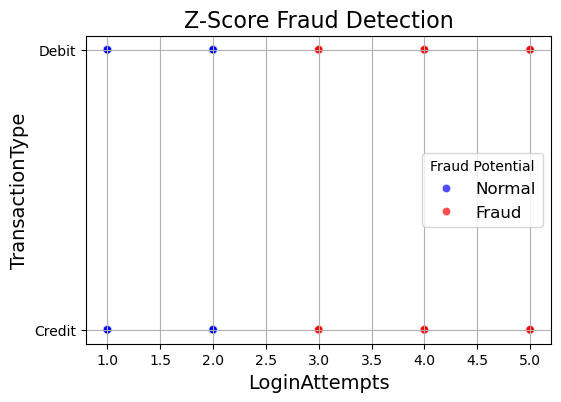

AccountBalance CustomerAge


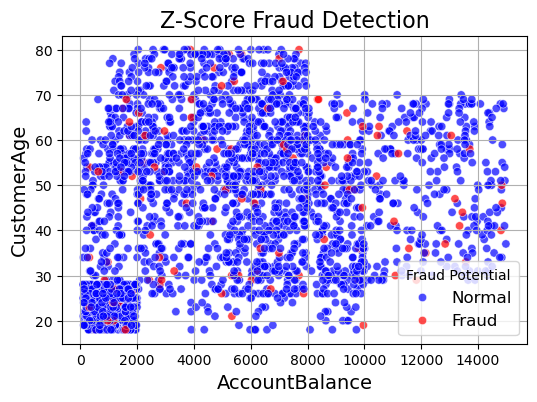

AccountBalance DaysSinceLastPurchase


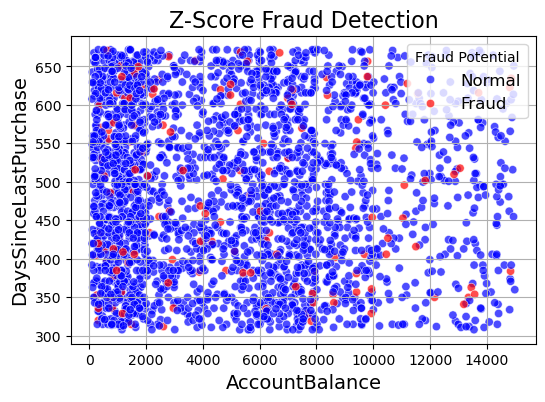

AccountBalance TransactionDate_hour


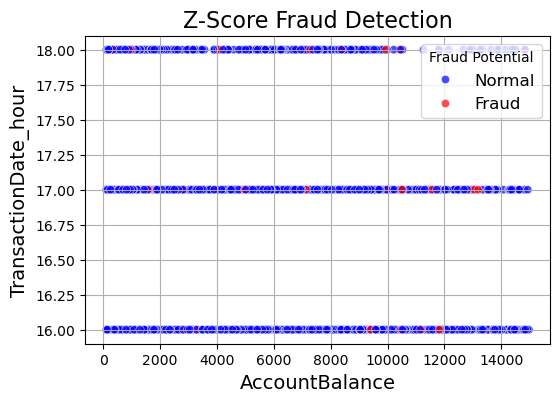

AccountBalance CustomerOccupation


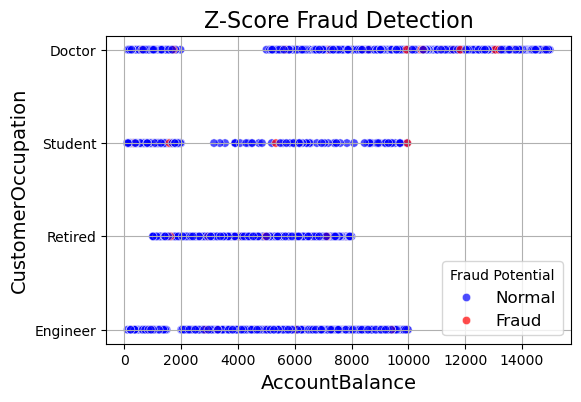

AccountBalance TransactionType


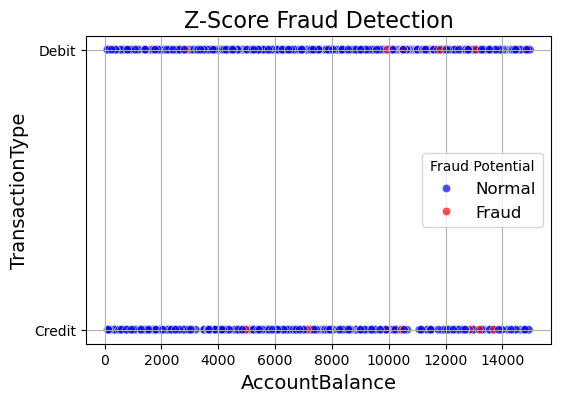

CustomerAge DaysSinceLastPurchase


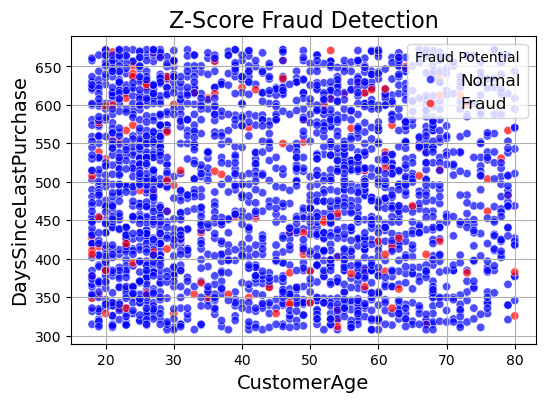

CustomerAge TransactionDate_hour


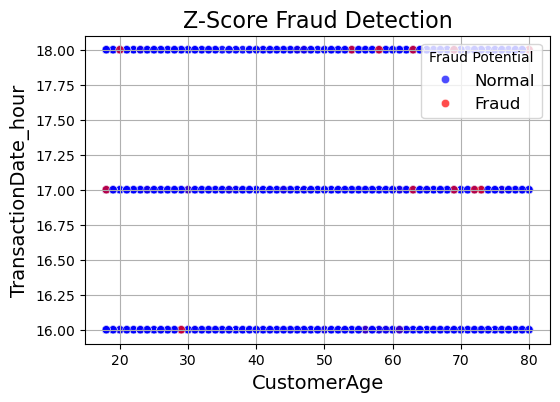

CustomerAge CustomerOccupation


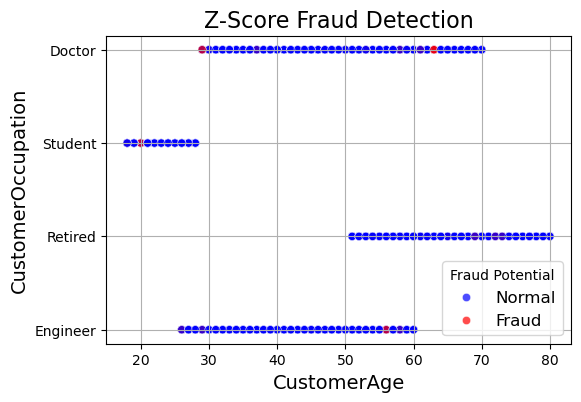

CustomerAge TransactionType


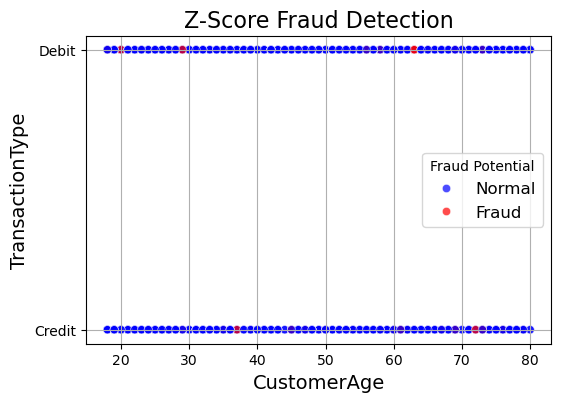

DaysSinceLastPurchase TransactionDate_hour


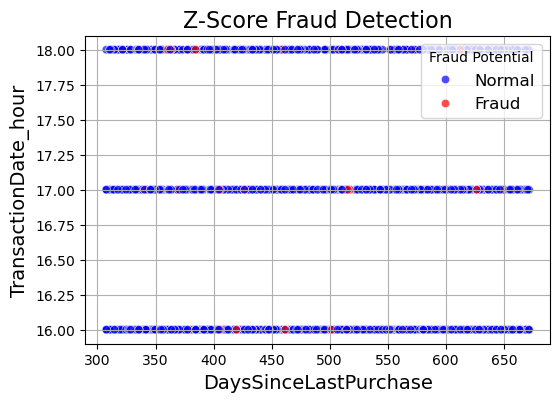

DaysSinceLastPurchase CustomerOccupation


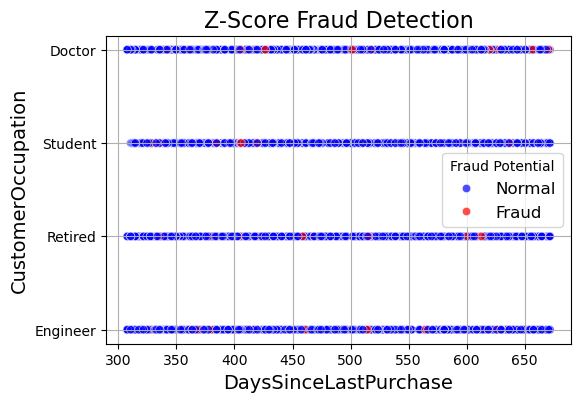

DaysSinceLastPurchase TransactionType


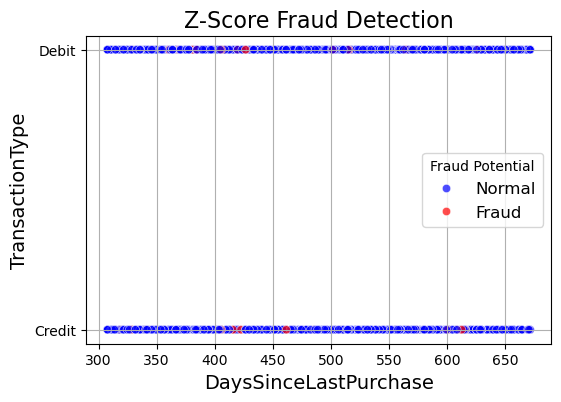

TransactionDate_hour CustomerOccupation


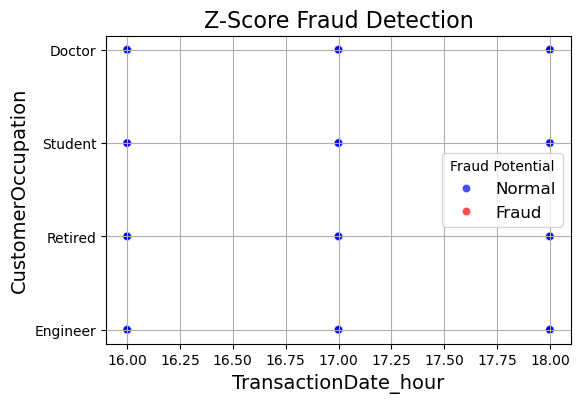

TransactionDate_hour TransactionType


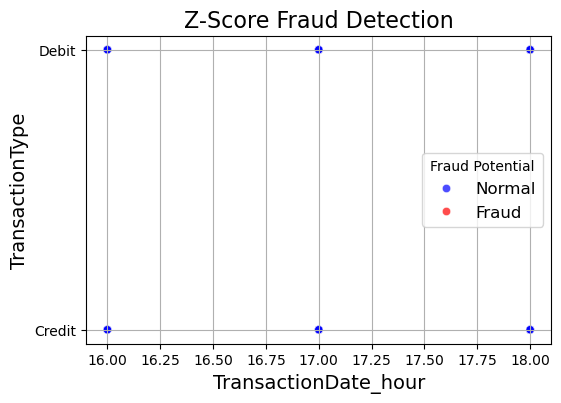

CustomerOccupation TransactionType


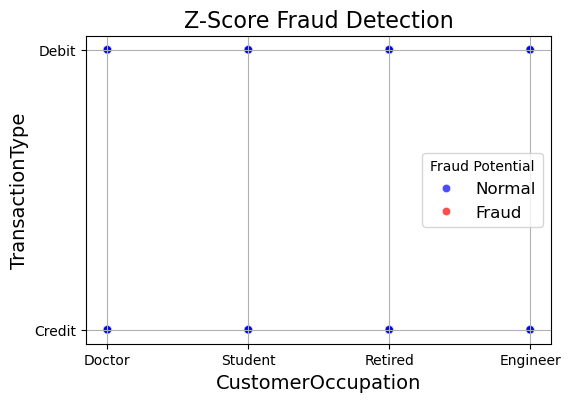

In [22]:
# Make plots of all of the variables in teh dataset, to understand which group is most afflicted
for pair in combinations:
    print(pair[0],pair[1])
    create_scatter(pair[0],pair[1], df, "plots")

In [23]:
# Of all the cases, there are some that have a statistical anamoly that constitutes fraud, these are
print("{} out of {} data entries have fraud characteristics, or {}% of the sample".format(fraud_count, df["Any_ZScore_Fraud"].count(),100*fraud_count/df["Any_ZScore_Fraud"].count()))

140 out of 2512 data entries have fraud characteristics, or 5.573248407643312% of the sample


In [24]:
# Now having a dataset of only the fraud candidates, what groups of people

TransactionAmount TransactionDuration


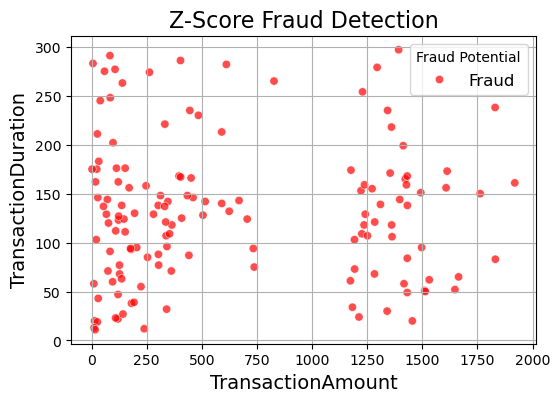

TransactionAmount LoginAttempts


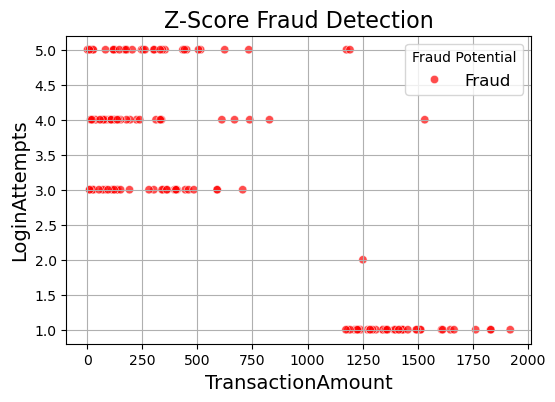

TransactionAmount AccountBalance


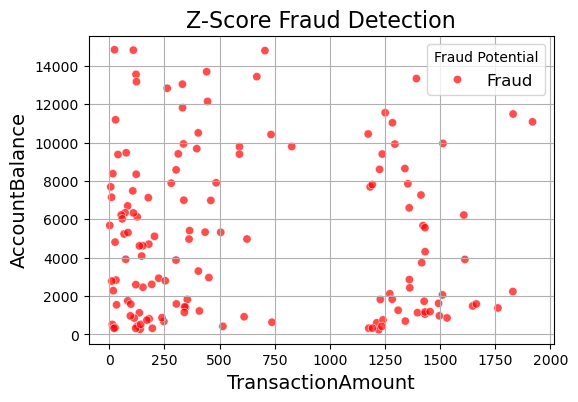

TransactionAmount CustomerAge


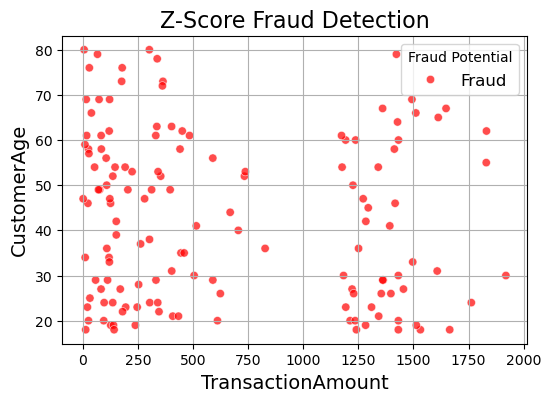

TransactionAmount DaysSinceLastPurchase


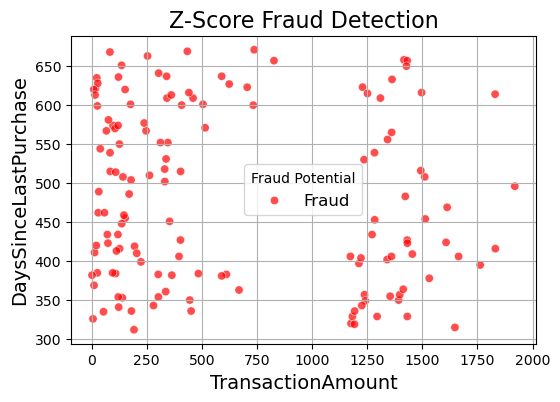

TransactionAmount TransactionDate_hour


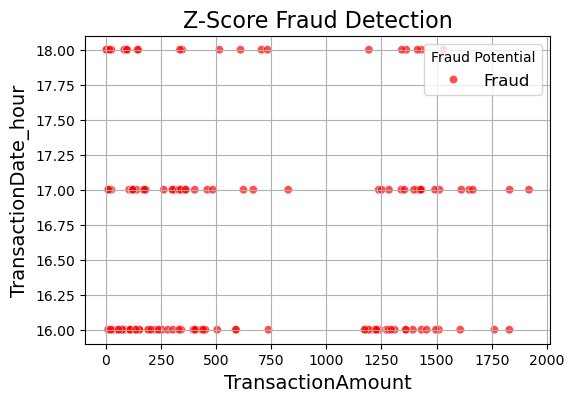

TransactionAmount CustomerOccupation


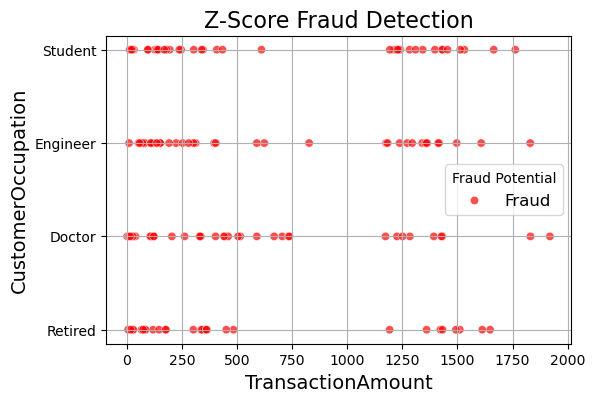

TransactionAmount TransactionType


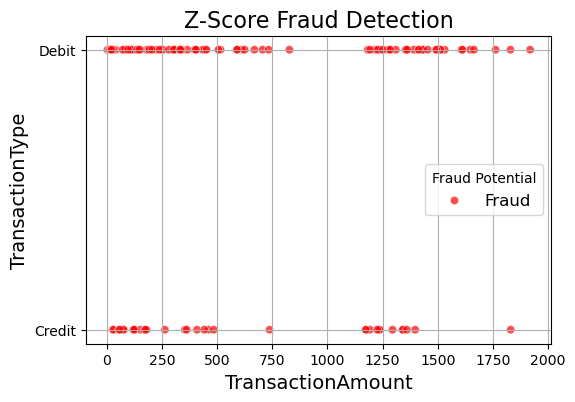

TransactionDuration LoginAttempts


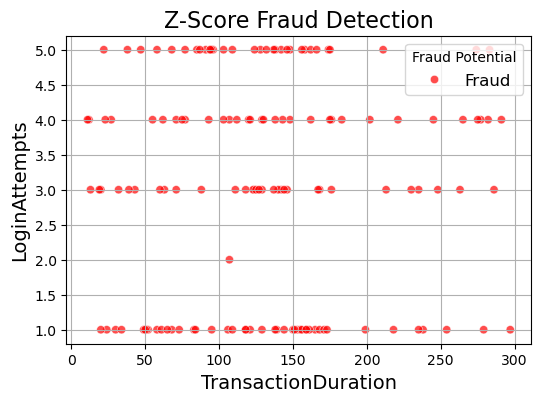

TransactionDuration AccountBalance


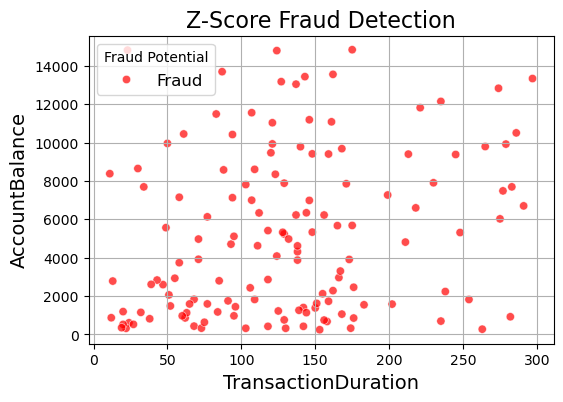

TransactionDuration CustomerAge


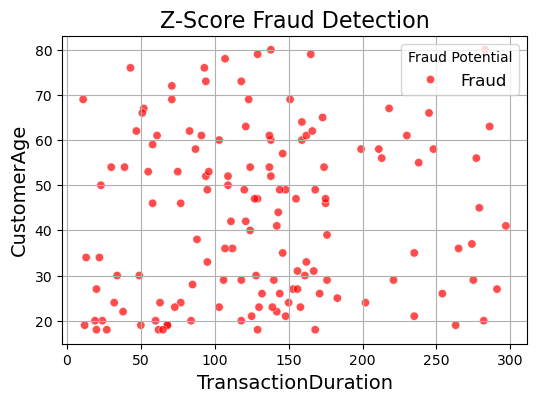

TransactionDuration DaysSinceLastPurchase


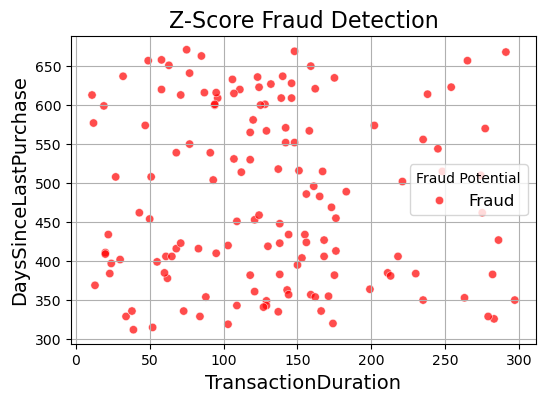

TransactionDuration TransactionDate_hour


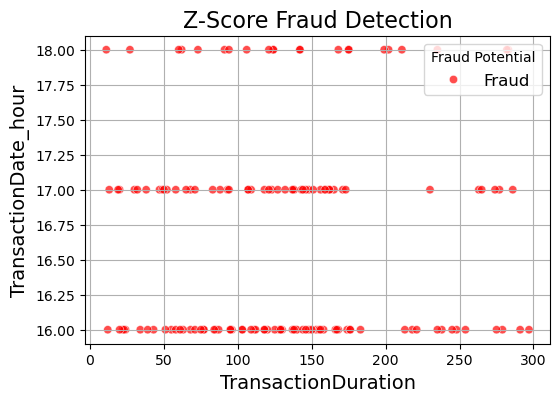

TransactionDuration CustomerOccupation


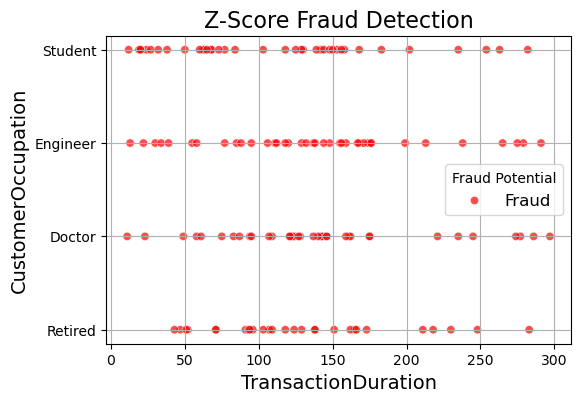

TransactionDuration TransactionType


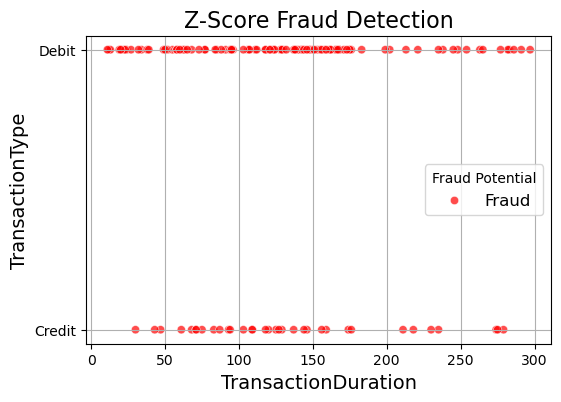

LoginAttempts AccountBalance


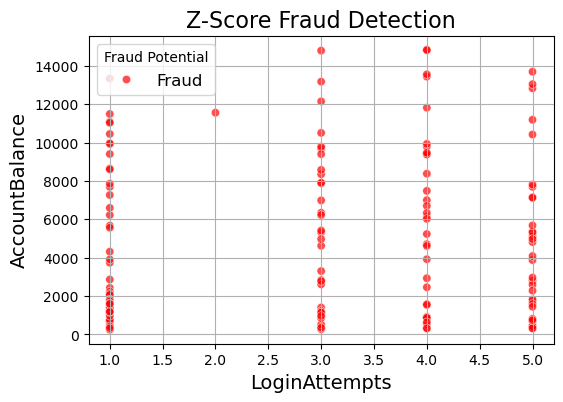

LoginAttempts CustomerAge


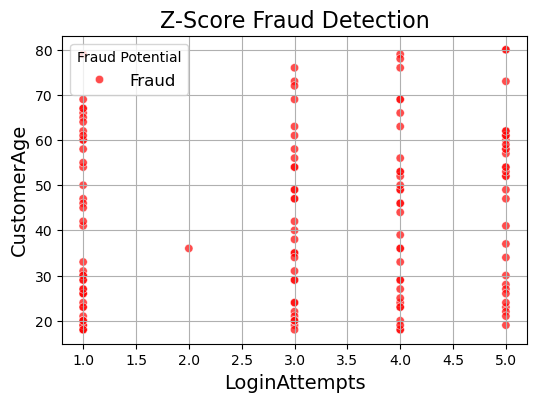

LoginAttempts DaysSinceLastPurchase


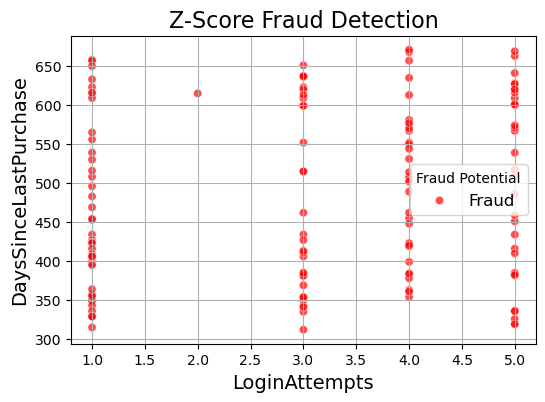

LoginAttempts TransactionDate_hour


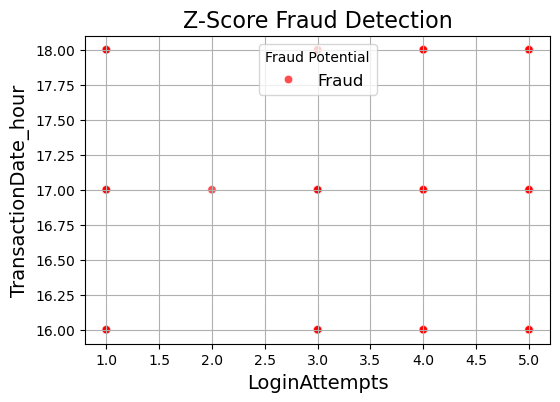

LoginAttempts CustomerOccupation


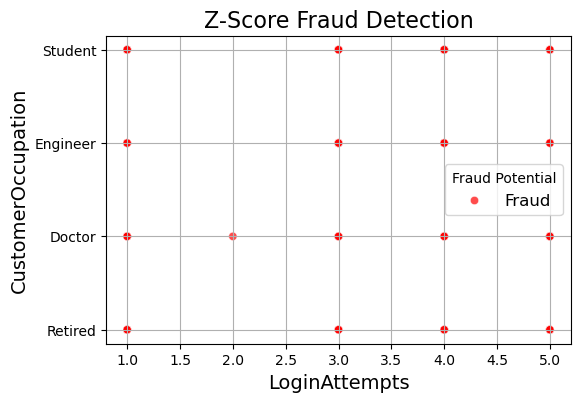

LoginAttempts TransactionType


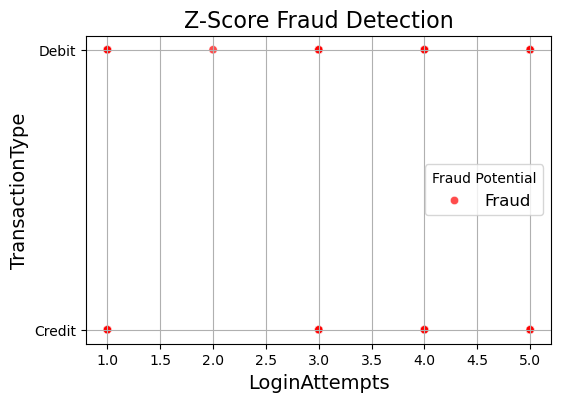

AccountBalance CustomerAge


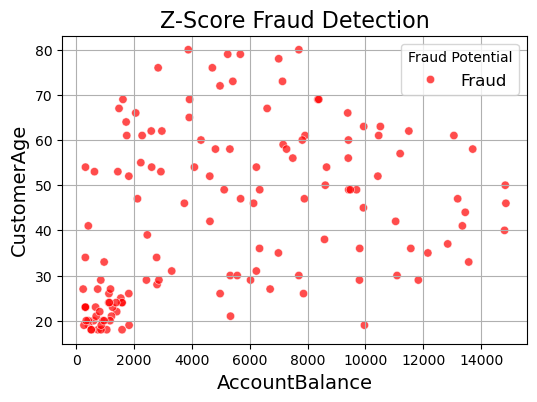

AccountBalance DaysSinceLastPurchase


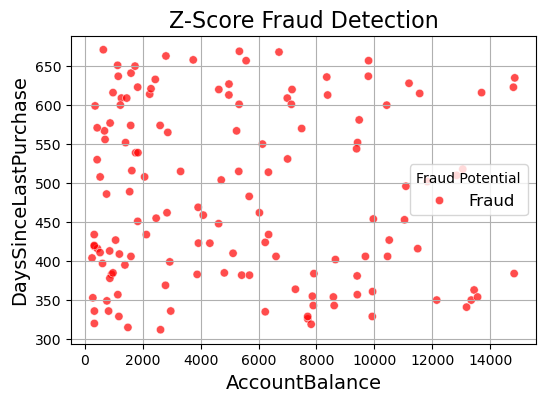

AccountBalance TransactionDate_hour


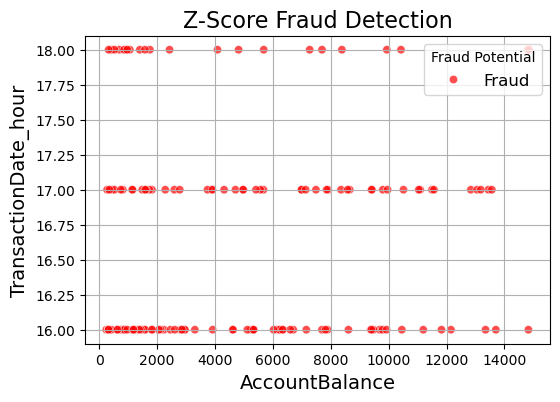

AccountBalance CustomerOccupation


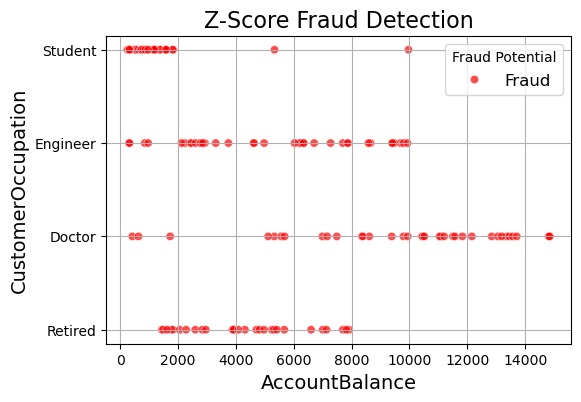

AccountBalance TransactionType


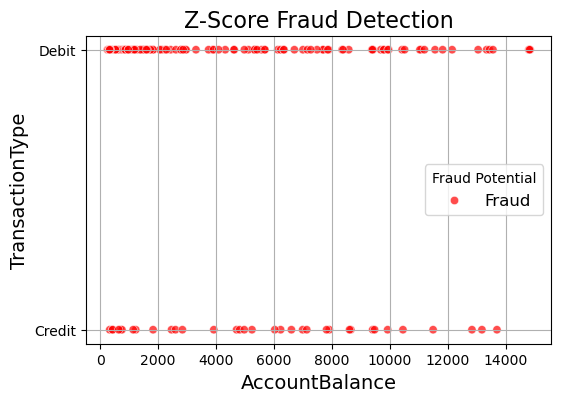

CustomerAge DaysSinceLastPurchase


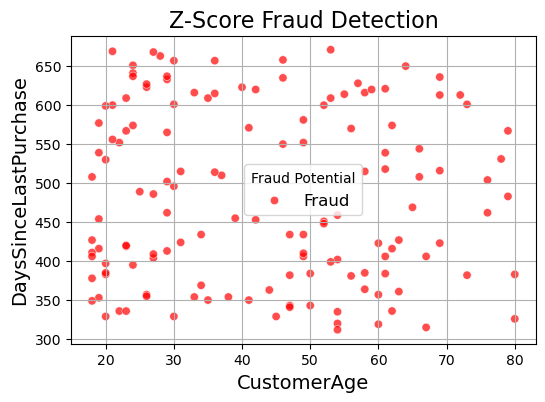

CustomerAge TransactionDate_hour


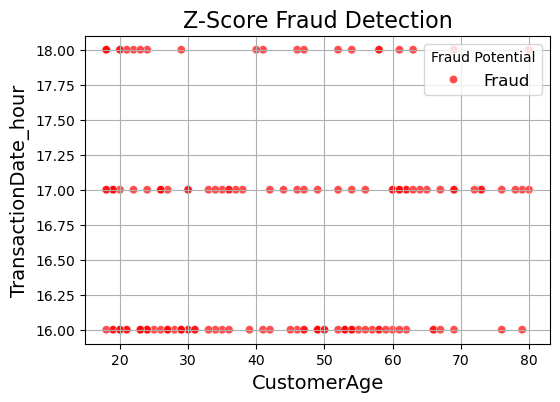

CustomerAge CustomerOccupation


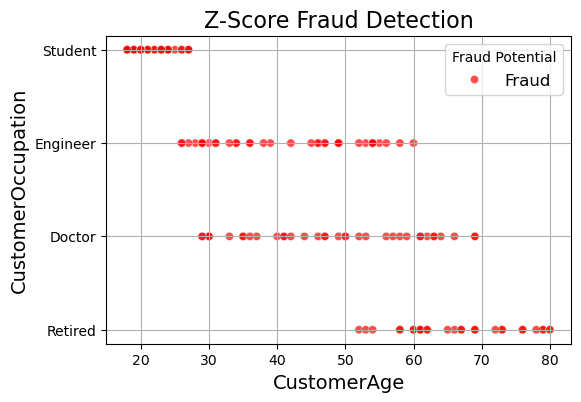

CustomerAge TransactionType


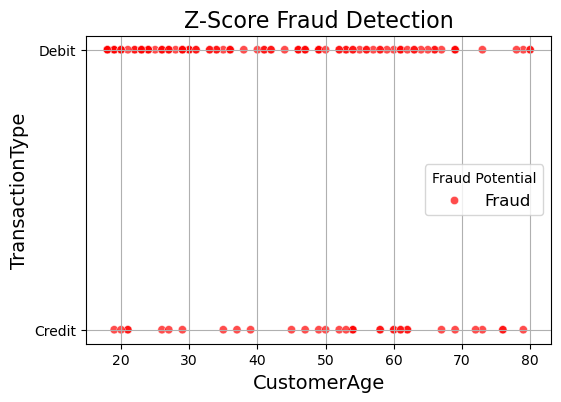

DaysSinceLastPurchase TransactionDate_hour


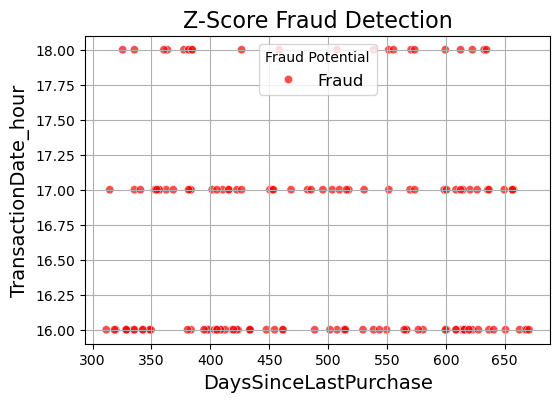

DaysSinceLastPurchase CustomerOccupation


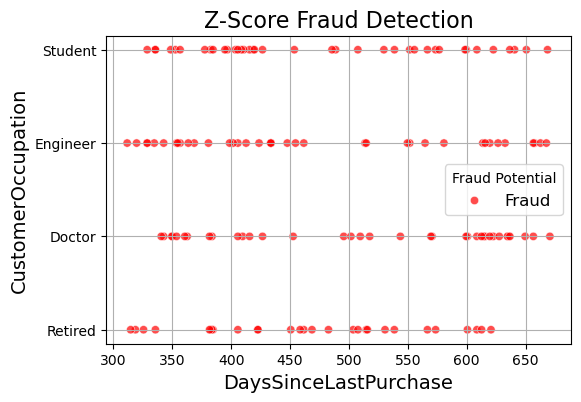

DaysSinceLastPurchase TransactionType


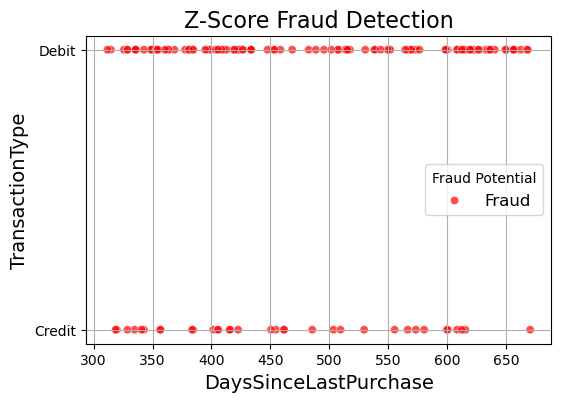

TransactionDate_hour CustomerOccupation


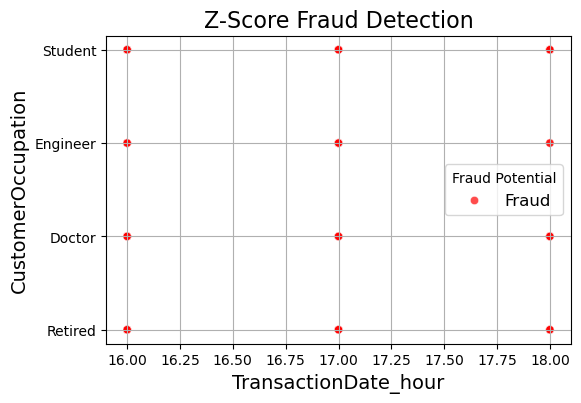

TransactionDate_hour TransactionType


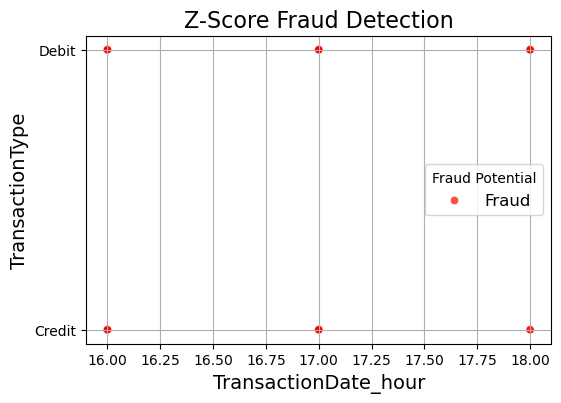

CustomerOccupation TransactionType


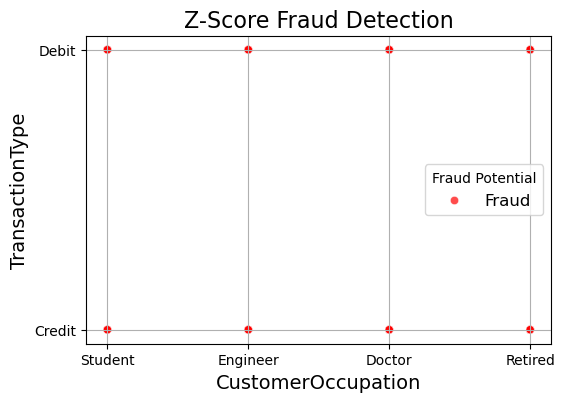

In [25]:
fraud_data = df[df["Any_ZScore_Fraud"]=="Fraud"]
for pair in combinations:
    print(pair[0],pair[1])
    create_scatter(pair[0],pair[1], fraud_data, "fraud_plots")

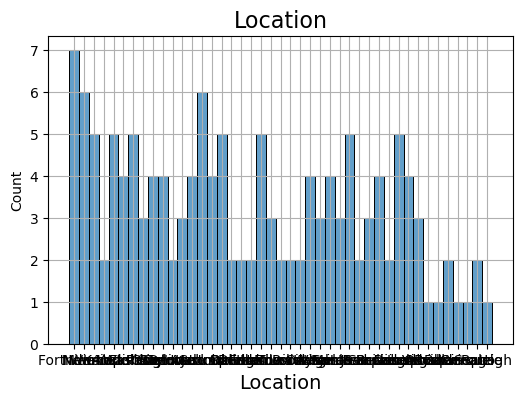

In [43]:
# What locations, if any are suffering the most from fraud?

create_histo_1d("Location",fraud_data)

location_fraud_data = fraud_data[["Any_ZScore_Fraud","Location"]]

location_fraud_data = location_fraud_data.groupby("Location").count().sort_values("Any_ZScore_Fraud", ascending=False)

In [64]:
location_fraud_data.




Any_ZScore_Fraud
Location                          
Fort Worth                       7
Miami                            6
Colorado Springs                 6
Jacksonville                     5
New York                         5
Oklahoma City                    5
El Paso                          5
Philadelphia                     5
Virginia Beach                   5
Austin                           5
Columbus                         4
Phoenix                          4
Mesa                             4
San Diego                        4
Charlotte                        4
Houston                          4
Kansas City                      4
Las Vegas                        4
Los Angeles                      4
San Antonio                      3
San Jose                         3
Nashville                        3
Louisville                       3
Washington                       3
Memphis                          3
Atlanta                          3
Milwaukee                        2
Tucson                           2
Seattle                          2
San Francisco                    2
Dallas                           2
Sacramento                       2
Albuquerque                      2
Portland                         2
Denver                           2
Detroit                          2
Fresno                           2
Indianapolis                     2
Chicago                          1
Omaha                            1
Boston                           1
Baltimore                        1
Raleigh                          1

In [77]:
# Lets grab only the locations that have at least 4 insances of fraud.
location_fraud_data_combined = location_fraud_data[location_fraud_data["Any_ZScore_Fraud"]>3]
less_fraud_cities = location_fraud_data[location_fraud_data["Any_ZScore_Fraud"]<3].sum()
print(less_fraud_cities)

location_fraud_data_combined.loc["Other"]=less_fraud_cities

print(location_fraud_data_combined)

Any_ZScore_Fraud    29
dtype: int64
                  Any_ZScore_Fraud
Location                          
Fort Worth                       7
Miami                            6
Colorado Springs                 6
Jacksonville                     5
New York                         5
Oklahoma City                    5
El Paso                          5
Philadelphia                     5
Virginia Beach                   5
Austin                           5
Columbus                         4
Phoenix                          4
Mesa                             4
San Diego                        4
Charlotte                        4
Houston                          4
Kansas City                      4
Las Vegas                        4
Los Angeles                      4
Other                           29


/var/folders/qj/3zmdfhnn4bxgc68lbfycnlt40000gn/T/ipykernel_17291/726007884.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_fraud_data_combined.loc["Other"]=less_fraud_cities


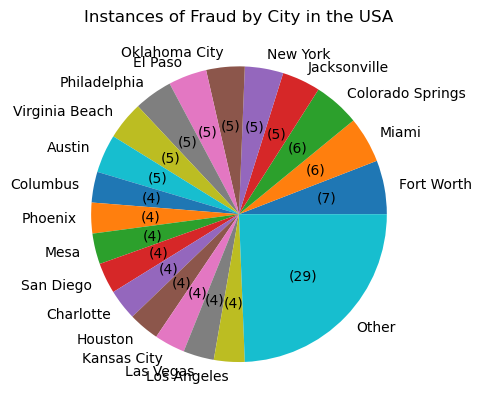

In [83]:
# Making a pie chart of the data
# Create the pie chart using Matplotlib
fraud_instances = list(location_fraud_data['Any_ZScore_Fraud'])
fraud_locations = list(location_fraud_data.index)


fraud_instances_combined = list(location_fraud_data_combined['Any_ZScore_Fraud'])
fraud_locations_combined = list(location_fraud_data_combined.index)


# plt.pie(fraud_instances, labels=fraud_locations, autopct='%1.1f%%')
plt.pie(fraud_instances_combined, labels=fraud_locations_combined, autopct=lambda pct: f'({int(pct/100.*sum(fraud_instances_combined))})')
# plt.pie(fraud_instances_combined, labels=fraud_locations_combined, autopct=lambda pct: f'{pct:.1f}% ({int(pct/100.*sum(fraud_instances_combined))})')

plt.title('Instances of Fraud by City in the USA')
plt.show()